In [1]:
import json
import os
import numpy as np
import networkx as nx
import matplotlib.image as mpimg
import matplotlib.pyplot as plt



In [4]:
with open('../Data/goals_matrices.json') as f:
    matrices = json.load(f)


In [5]:
mat = np.array(matrices['1619']['total_region_matrix'])
mat_norm = (mat-np.min(mat))/(np.max(mat)-np.min(mat))

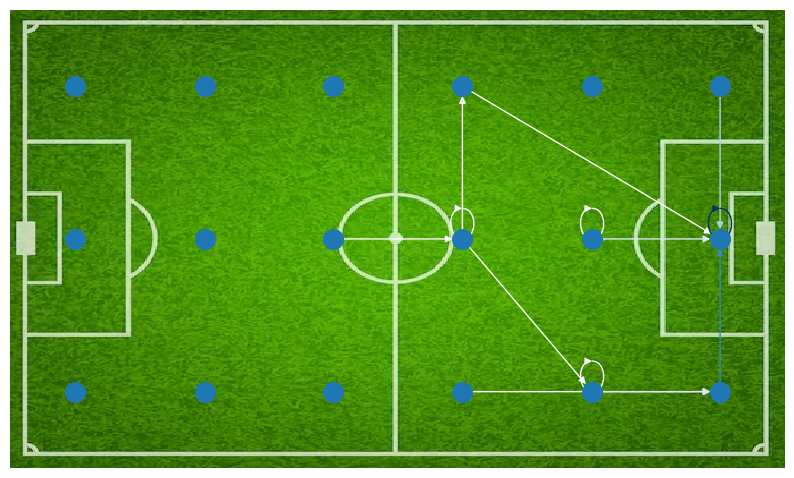

In [6]:
img = mpimg.imread('../images/pitch3.png')
extent = [0, 406, 0, 240]

x = [34, 34, 34, 102, 102, 102, 169, 169, 169, 237, 237, 237, 305, 305, 305, 372, 372, 372]
y = [200, 120, 40, 200, 120, 40, 200, 120, 40, 200, 120, 40, 200, 120, 40, 200, 120, 40]
# x = [34, 80, 70, 70, 80, 230, 220, 220, 230, 340, 340]
# y = [120, 200, 140, 100, 40, 200, 140, 100, 40, 150, 90]
coords = {}
for i in range(18):
    coords[i] = zip([x[i], y[i]])

G = nx.from_numpy_array(np.matrix(mat), create_using=nx.DiGraph)
coords = list(zip(x,y))

fig = plt.figure(frameon=False, figsize=(10,19))

plt.imshow(img, extent=extent, interpolation='nearest')
pos = {}
for i in range(18):
    pos[i] = coords[i]
edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]

nx.draw(G,
        pos=pos,
        node_size=200,
        edge_color=edgewidth,
        edge_cmap=plt.cm.Blues,
        )

plt.show()

    


In [8]:
centralities = {}
for team in matrices:
    centralities[team] = {}
    mat = np.array(matrices[team]['total_region_matrix'])
    mat_norm = (mat-np.min(mat))/(np.max(mat)-np.min(mat))
    centralities[team]['in_degree'] = mat.sum(axis = 0)
    centralities[team]['out_degree'] = mat.sum(axis = 1)

    centralities[team]['avg_in_degree'] = sum(centralities[team]['in_degree'])/18
    centralities[team]['avg_out_degree'] = sum(centralities[team]['out_degree'])/18
    
    clustering_coef = {}
    avg_clustering_coef = 0
    for i in range(len(mat)):
        clust_coef = 0
        for j in range(len(mat)):
            for k in range(len(mat)):
                clust_coef += (mat[i][j] * mat[k][j] * mat[k][i]) ** (1/3)
        node_out_degree = centralities[team]['out_degree'][i]
        if node_out_degree > 1:
            clustering_coef[i] = (1/(node_out_degree * (node_out_degree - 1) * mat.max())) * clust_coef
            avg_clustering_coef += clustering_coef[i]
        else:
            clustering_coef[i] = 0
    centralities[team]['clustering_coef'] = clustering_coef
    centralities[team]['avg_clustering_coef'] = avg_clustering_coef/len(mat_norm)
    
    mat_inv = 1/np.array(matrices[team]['total_region_matrix'])
    mat_inv[mat_inv == np.inf] = 0
    closeness = {}
    avg_closeness = 0
    for i in range(len(mat_inv)):
        closeness_denom = 0
        for j in range(len(mat)):
            if i != j:
                closeness_denom += mat_inv[i][j] + mat_inv[j][i]
        if closeness_denom > 0 :
            closeness[i] = (len(mat_inv)-1) / closeness_denom
            avg_closeness += closeness[i]
        else:
            closeness[i] = 0
    centralities[team]['closeness'] = closeness
    centralities[team]['avg_closeness'] = avg_closeness/18

    G_inv = nx.from_numpy_array(np.matrix(mat_inv), create_using=nx.DiGraph)
    betweenness = {}
    avg_betweenness = 0
    for i in range((len(mat))):
        between = 0
        for j in range(len(mat)):
            for k in range(len(mat)):
                if nx.has_path(G_inv, j, k):
                    paths = list(nx.all_shortest_paths(G_inv, source=j, target=k, weight="weight"))
                    num_geodesic = len(paths)
                    num_geodesic_i = len([p for p in paths if i in p])
                    between += num_geodesic_i/num_geodesic
        betweenness[i] = between/(17*16)
        avg_betweenness += betweenness[i]
    centralities[team]['betweenness'] = betweenness
    centralities[team]['avg_betweenness'] = avg_betweenness/18
    
    



/var/folders/2d/s_tm5mf52ys_h7z2hk8cwl100000gn/T/ipykernel_71265/786738094.py:28: RuntimeWarning: divide by zero encountered in divide
  mat_inv = 1/np.array(matrices[team]['total_region_matrix'])


In [ ]:
teams_dict = {}
with open("../Data/teams.json") as f:
        teams = json.load(f)
        for team in teams:
            if team['type'] == 'club':
                teams_dict[team['wyId']] = team['name']

for t in centralities:
    print(teams_dict[int(t)], centralities[t]['avg_closeness'])